In [104]:
import rosbag
from thllib import flylib
import numpy as np
import os
import h5py
import cv2
import sys
from matplotlib import pyplot as plt
from scipy import ndimage

#%matplotlib inline
#from matplotlib import pyplot as plt

flynum = 1355
samp_range = 1000 # search over this range to find center point of image
search_bound = 50 # window to search for center of fly in pxls
crop = 100 #crop fly around this window

fly = flylib.NetFly(flynum)
bag_file_name = fly.flypath + '/' + [bf for bf in os.listdir(fly.flypath) if '.bag' in bf][0]
inbag = rosbag.Bag(bag_file_name)
topics = inbag.get_type_and_topic_info()[1].keys()

img_msgs = [(topic,msg,t) for topic,msg,t in inbag.read_messages(topics = '/camera/image_raw/compressed')]

#samp_range = len(msgs)
#mid_trial = len(img_msgs)/2 
s_start = 0#mid_trial - samp_range/2
s_end = len(img_msgs)#mid_trial + samp_range/2

def decode_img_msg(msg):
    import cv2
    img_np_arr = np.fromstring(msg[1].data, np.uint8)
    img = cv2.imdecode(img_np_arr,cv2.IMREAD_GRAYSCALE)
    img = cv2.pyrDown(img)
    return img#[imt[0]:imt[1],imt[2]:imt[3]]

imgs = [decode_img_msg(img_msgs[i]) for i in sorted(np.random.choice(np.arange(s_start,s_end),
                                                         size = samp_range,
                                                         replace = False))]
max_img = (255-np.std(imgs,axis = 0))
max_img = (255-np.std(imgs,axis = 0))

In [211]:
np.linspace(0,len(fly.images),100).astype(int)

array([   0,   20,   40,   61,   81,  102,  122,  142,  163,  183,  204,
        224,  244,  265,  285,  306,  326,  346,  367,  387,  408,  428,
        448,  469,  489,  510,  530,  551,  571,  591,  612,  632,  653,
        673,  693,  714,  734,  755,  775,  795,  816,  836,  857,  877,
        897,  918,  938,  959,  979, 1000])

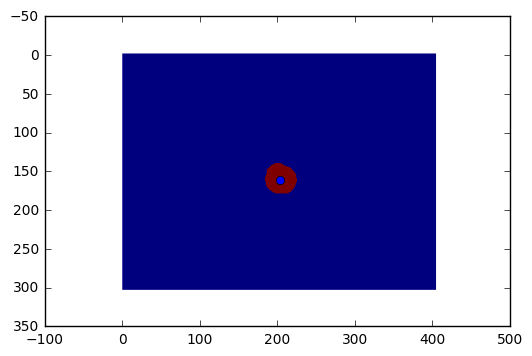

In [168]:
max_img = (255-np.mean(imgs,axis = 0))
r,c = max_img.shape
rr,cc = np.meshgrid(np.arange(0,r),np.arange(0,c))
outside = np.sqrt((rr-(r/2.))**2 + (cc-(c/2.))**2)>100
max_img[outside.T] = 0
th_img = (max_img) > 240
cc,rc = ndimage.center_of_mass(th_img[(r/2)-search_bound:(r/2)+search_bound,(c/2)-search_bound:(c/2)+search_bound])
center = (rc+(c/2)-search_bound,cc+(r/2)-search_bound)

plt.imshow(th_img)#,vmin = 0,vmax = 255)
plt.plot(center[0],center[1],'o')
#plt.gca().set_xbound(200,600)
#plt.gca().set_ybound(200,600)

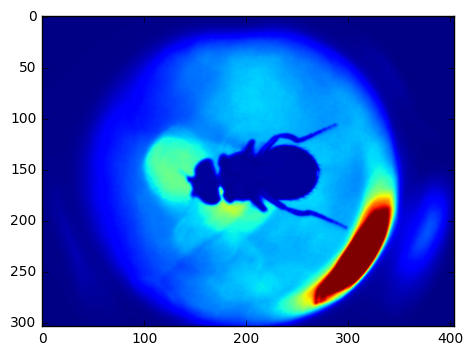

In [84]:
plt.imshow(imgs[100])

In [48]:
#H, edges = np.histogram(imgs)

In [187]:
bls = np.arange(0,255,1)
brs = bls + 1
H = [np.sum((np.array(imgs[::5])>bl) & (np.array(imgs[::5])<=br),axis = 0) for bl,br in zip(bls,brs)]

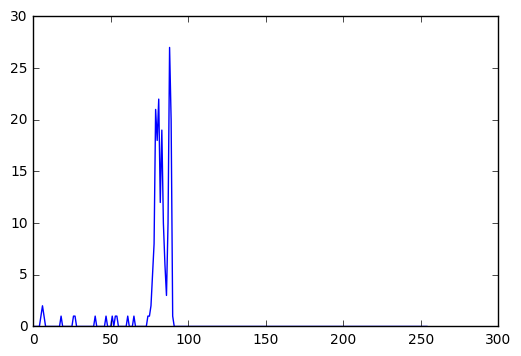

In [188]:
plt.plot(np.array(H)[:,100,200])

In [241]:
import numpy as np
from numpy.linalg import eig, inv

def fitEllipse(x,y):
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    S = np.dot(D.T,D)
    C = np.zeros([6,6])
    C[0,2] = C[2,0] = 2; C[1,1] = -1
    E, V =  eig(np.dot(inv(S), C))
    n = np.argmax(np.abs(E))
    a = V[:,n]
    return a

def ellipse_center(a):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    num = b*b-a*c
    x0=(c*d-b*f)/num
    y0=(a*f-b*d)/num
    return np.array([x0,y0])


#def ellipse_angle_of_rotation( a ):
#    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
#    return 0.5*np.arctan(2*b/(a-c))

def ellipse_angle_of_rotation2( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    if b == 0:
        if a > c:
            return 0
        else:
            return np.pi/2
    else:
        if a > c:
            return np.arctan(2*b/(a-c))/2
        else:
            return np.pi/2 + np.arctan(2*b/(a-c))/2

def ellipse_axis_length( a ):
    b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    res1=np.sqrt(up/down1)
    res2=np.sqrt(up/down2)
    return np.array([res1, res2])

In [298]:
r,c = np.shape(imgs[100])

In [299]:
rr,cc = np.meshgrid(np.arange(0,r),np.arange(0,c))

In [341]:
img = imgs[600]
img[outside.T] = 255

In [342]:
bk_img = np.percentile(imgs,90,axis = 0)

In [343]:
pnts = img<40

In [344]:
x = cc[pnts.T];y = rr[pnts.T]

In [345]:
a = fitEllipse(x,y)

In [346]:
cx,cy = ellipse_center(a)

In [347]:
theta = ellipse_angle_of_rotation2(a)

In [348]:
th = np.rad2deg(theta)

In [349]:
theta

1.0716776285709435

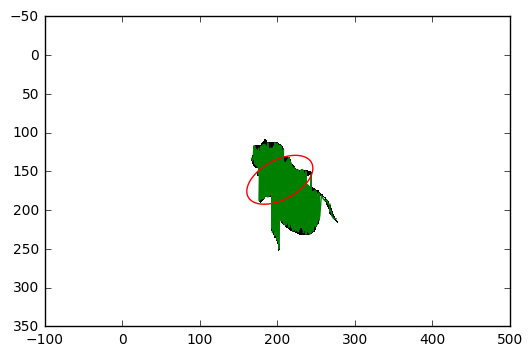

In [350]:
arc = 2.0
R = np.arange(0,arc*np.pi, 0.01)
plt.imshow(img>40,cmap = plt.cm.gray,aspect = 'equal',interpolation = 'None')
plt.plot(cx,cy,'o')
plt.plot(x[::10],y[::10])
phi = ellipse_angle_of_rotation2(a)
axes = ellipse_axis_length(a)
aa, bb = axes
xx = center[0] + aa*np.cos(R)*np.cos(phi) - bb*np.sin(R)*np.sin(phi)
yy = center[1] + aa*np.cos(R)*np.sin(phi) + bb*np.sin(R)*np.cos(phi)
plt.plot(xx,yy, color = 'red')

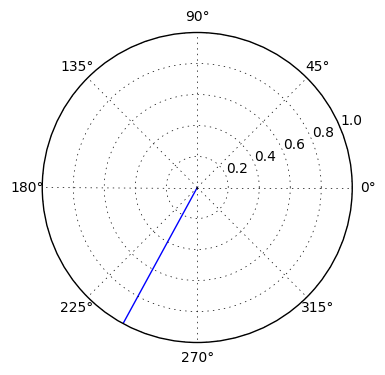

In [295]:
ax = plt.subplot(1,1,1,projection = 'polar')
ax.plot([0,theta+np.pi],[0,1])

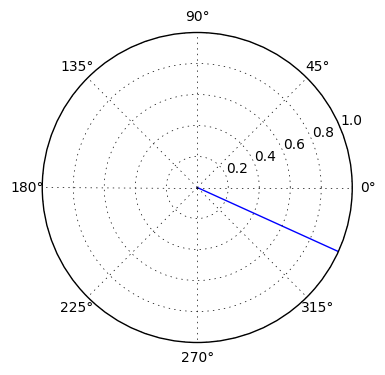

In [245]:
plt.imshow(img,cmap = plt.cm.gray)
plt.plot(cx,cy,'o')
ax = plt.subplot(1,1,1,projection = 'polar')
ax.plot([theta,theta],[0,1])

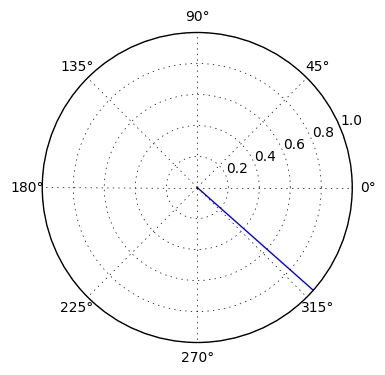

In [190]:
plt.imshow(img,cmap = plt.cm.gray)
plt.plot(cy,cx,'o')
ax = plt.subplot(1,1,1,projection = 'polar')
ax.plot([th,th],[0,1])

In [42]:
from scipy import stats

In [136]:
cond_msgs = [(topic,msg,t) for topic,msg,t in inbag.read_messages(topics = '/magnotether/condition')]

In [150]:
fly.save_txt?

Signature: fly.save_txt(string, filename)
Docstring: <no docstring>
File:      /media/imager/FlyDataD/src/thllib/flylib.py
Type:      instancemethod


In [124]:
fly.times

AttributeError: 'NetFly' object has no attribute 'times'

In [125]:
cond_msgs[0][2].to_time()

1502476620.2160017

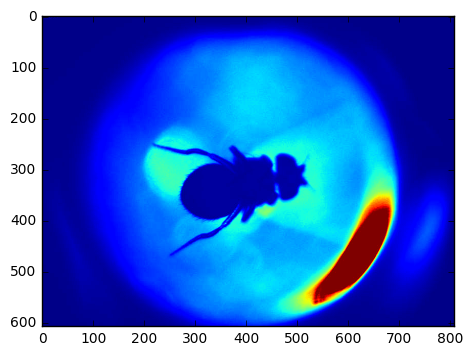

In [126]:
plt.imshow(imgs[300])plt.imshow(imgs[300])

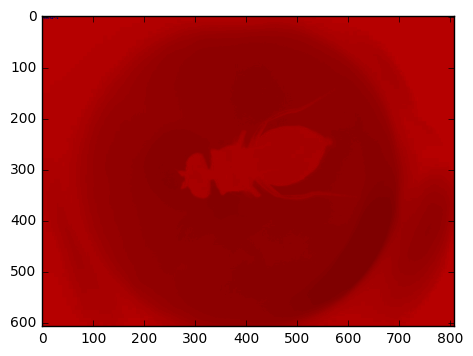

In [71]:
plt.imshow(imgs[100]**0.01)

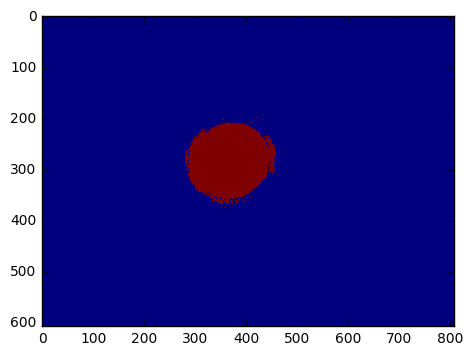

In [69]:
plt.imshow(th_img)

In [49]:
%matplotlib inline
#from matplotlib import pyplot as plt

In [65]:
img_msgs[10][1].header.stamp.to_time()

1502333398.1148112

In [351]:
import rosbag
from thllib import flylib
import numpy as np
import os
import h5py
import cv2
import sys
from matplotlib import pyplot as plt
from scipy import ndimage

In [352]:
flynum = 1360

In [353]:
fly = flylib.NetFly(flynum)

In [354]:
fly.open_signals('hdf5')

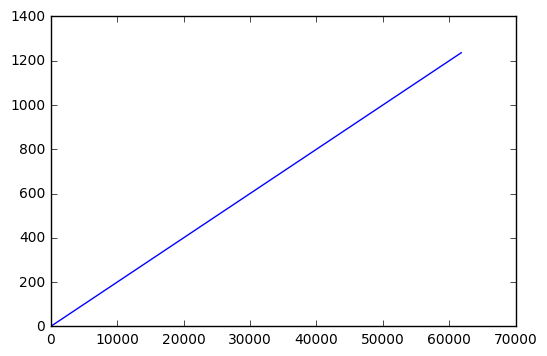

In [355]:
plt.plot(fly.times)

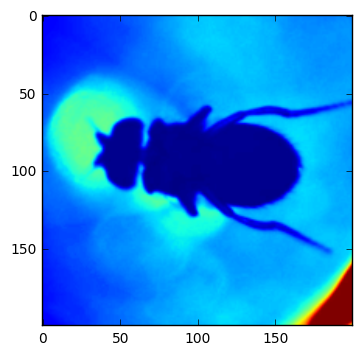

In [365]:
plt.imshow(fly.images[100])

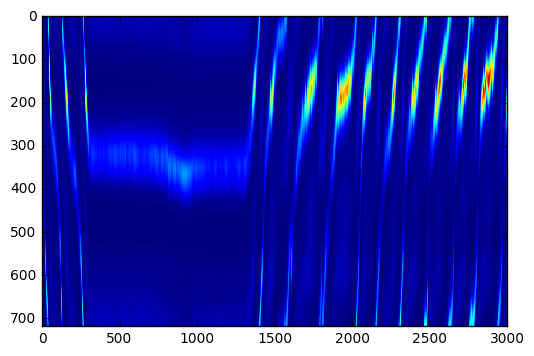

In [358]:
plt.imshow(np.array(fly.correlations[6000:9000]).T**4,aspect = 'auto')
DID SUSPECT HAVE HELP? 
More charges possible after 
deadly violence in Charlottesville
￼
Pence: 'No tolerance' for hate from white supremacists, neo-Nazis, KKK
Charlottesville vigil honors victims one day later
Trump condemns 'white supremacists,' other extremists behind deadly Virginia rallies
Heather Heyer, Charlottesville victim, 32, was Virginia paralegal: report
AG Jeff Sessions announces probe into deadly Charlottesville car crash
Katie Couric says her producers were sprayed with urine in Charlottesville
Scaramucci critical of Bannon, Trump's response to deadly Virginia rally
Charlottesville suspect's mom told him to protest 'peacefully'
Charlottesville rally organizer spat at, chased from press conference by protesters; 1 arrested

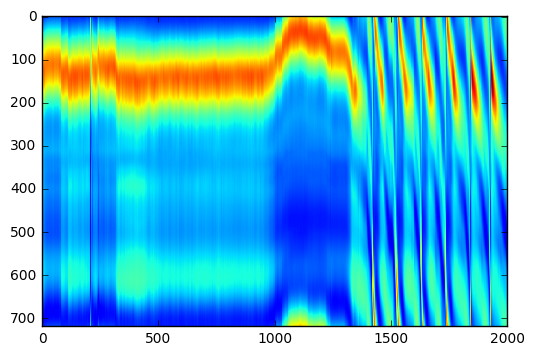

In [360]:
plt.imshow(np.array(fly.correlations[3000:5000]).T,aspect = 'auto')

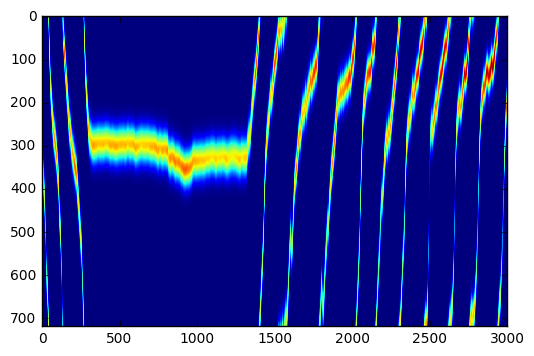

In [100]:
plt.imshow(np.array(fly.state_estimates[6000:9000]).T**4,aspect = 'auto')#,vmin = 0,vmax = 0.05)
#plt.plot(np.argmax(fly.state_estimates[1000:2000],axis = 1))

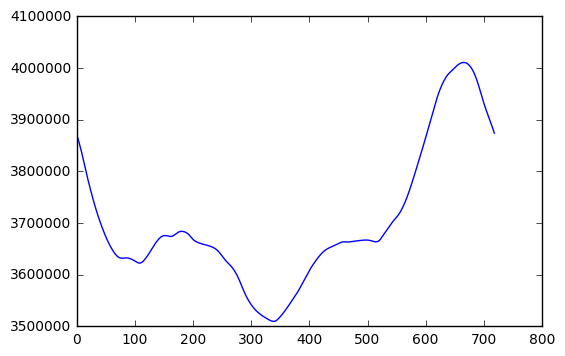

In [61]:
plt.plot(fly.correlations[1420])

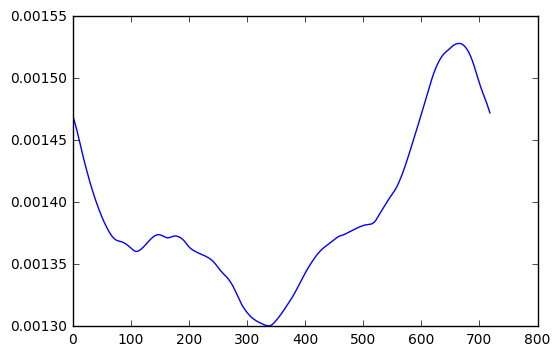

In [62]:
plt.plot(fly.state_estimates[1420])

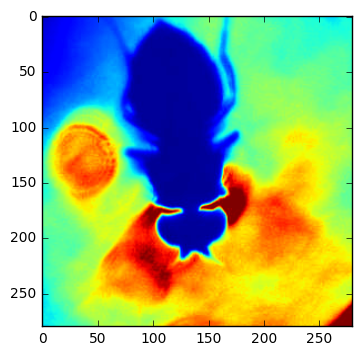

In [56]:
plt.imshow(fly.images[20000])

In [2]:
import subprocess

In [3]:
ps_dir = '/media/imager/FlyDataD/Projects/012_magnotether/'
#subprocess.call([ps_dir + 'unbag.py','1361'])

In [366]:
flylist = [1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364]

In [368]:
prss = [subprocess.Popen([ps_dir + 'unbag.py',str(fn)]) for fn in flylist]

In [384]:
prss = [subprocess.Popen([ps_dir + 'track_fly.py',str(fn)]) for fn in flylist]

In [391]:
prss = [subprocess.Popen([ps_dir + 'circular_bayes.py',str(fn)]) for fn in flylist]

In [394]:
prss = [subprocess.Popen([ps_dir + 'make_movie.py',str(fn)]) for fn in flylist]

In [409]:
flylist = [1359]

In [410]:
prss = [subprocess.Popen([ps_dir + 'make_movie.py',str(fn)]) for fn in flylist]

In [4]:
p1 = subprocess.Popen([ps_dir + 'unbag.py','1360'])

In [4]:
p1 = subprocess.Popen([ps_dir + 'track_fly.py','1360'])

In [7]:
p1 = subprocess.Popen([ps_dir + 'circular_bayes.py','1360'])

In [416]:
p1 = subprocess.Popen([ps_dir + 'make_movie.py','1357'])

In [415]:
[p.poll() for p in prss]

[None]